In [1]:
# Imports and Spark Session Initialization (The Definitive Windows Fix is Applied Here)
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg, round, count, lit, when, floor, min, max
from pyspark.sql.types import IntegerType
import pandas as pd
import matplotlib.pyplot as plt

# Set critical Spark configurations to bypass native Windows I/O issues
spark = SparkSession.builder \
    .appName("CarDatasetAnalysis") \
    .config("spark.hadoop.mapreduce.fileoutputcommitter.algorithm.version", "2") \
    .config("spark.speculation", "false") \
    .config("spark.hadoop.mapreduce.fileoutputcommitter.class", "org.apache.hadoop.mapreduce.lib.output.FileOutputCommitter") \
    .config("spark.hadoop.fs.file.impl", "org.apache.hadoop.fs.LocalFileSystem") \
    .getOrCreate()

# Set log level to minimize verbosity
spark.sparkContext.setLogLevel("ERROR")

print("Spark Session Initialized.")

Spark Session Initialized.


In [2]:
# Load Data and Initial Exploration
file_path = 'car_sale_dataset.csv'

# Read the CSV file into a Spark DataFrame
df = spark.read.csv(file_path, header=True, inferSchema=True)

print("--- PySpark DataFrame Schema ---")
df.printSchema()

print("\n--- First 5 Rows of Data ---")
df.show(5)

--- PySpark DataFrame Schema ---
root
 |-- Manufacturer: string (nullable = true)
 |-- Model: string (nullable = true)
 |-- Engine size: double (nullable = true)
 |-- Fuel type: string (nullable = true)
 |-- Year of manufacture: integer (nullable = true)
 |-- Mileage: integer (nullable = true)
 |-- Price: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Price_per_km: double (nullable = true)
 |-- Category: string (nullable = true)
 |-- Mileage_Group: string (nullable = true)


--- First 5 Rows of Data ---
+------------+----------+-----------+---------+-------------------+-------+-----+---+------------+--------+-------------+
|Manufacturer|     Model|Engine size|Fuel type|Year of manufacture|Mileage|Price|Age|Price_per_km|Category|Mileage_Group|
+------------+----------+-----------+---------+-------------------+-------+-----+---+------------+--------+-------------+
|     Porsche|718 Cayman|        4.0|   Petrol|               2016|  57850|49704|  9|      0.8592| Premiu

In [3]:
# Aggregation - Average Price and Mileage by Manufacturer
print("--- Average Price and Mileage by Manufacturer (PySpark) ---")

# Group by Manufacturer and calculate the mean of Price and Mileage
manufacturer_summary_df = df.groupBy("Manufacturer") \
    .agg(\
        round(avg("Price"), 2).alias("Average_Price"),\
        round(avg("Mileage"), 0).cast(IntegerType()).alias("Average_Mileage")\
    ) \
    .sort(col("Average_Price").desc())

# Show the results (Table)
manufacturer_summary_df.show()

--- Average Price and Mileage by Manufacturer (PySpark) ---
+------------+-------------+---------------+
|Manufacturer|Average_Price|Average_Mileage|
+------------+-------------+---------------+
|     Porsche|     51476.83|          55796|
|         BMW|     49325.33|          52320|
|      Toyota|      34939.3|          39370|
|        Ford|     29760.16|          32735|
|          VW|     29159.33|          30923|
+------------+-------------+---------------+



In [4]:
# Transformation - Creating a Mileage Group (Categorical Binning)
print("--- Transformation: Creating 'Mileage_Group' ---")

# Calculate the mileage quartiles
mileage_quantiles = df.approxQuantile("Mileage", [0.25, 0.5, 0.75], 0.01)
q1, q2, q3 = mileage_quantiles[0], mileage_quantiles[1], mileage_quantiles[2]
print(f"Calculated Mileage Quartiles (Q1, Q2, Q3): {q1}, {q2}, {q3}")

# Use 'when().otherwise()' to create the categorical bins
df_transformed = df.withColumn(
    "Mileage_Group",
    when(col("Mileage") < q1, lit("Low"))
    .when((col("Mileage") >= q1) & (col("Mileage") < q2), lit("Medium"))
    .when((col("Mileage") >= q2) & (col("Mileage") < q3), lit("High"))
    .otherwise(lit("Very High"))
)

# Display the value counts for the new column (Table)
print("\n--- Value Counts for New 'Mileage_Group' Column ---")
mileage_counts_df = df_transformed.groupBy("Mileage_Group").count().sort(col("count").desc())
mileage_counts_df.show()

--- Transformation: Creating 'Mileage_Group' ---
Calculated Mileage Quartiles (Q1, Q2, Q3): 21913.0, 35200.0, 52241.0

--- Value Counts for New 'Mileage_Group' Column ---
+-------------+-----+
|Mileage_Group|count|
+-------------+-----+
|    Very High| 3031|
|          Low| 2940|
|         High| 2913|
|       Medium| 2889|
+-------------+-----+



In [5]:
# Filtering - Select only 'Premium' category cars
print("--- Filtering: 'Premium' Cars Dataset ---")

# Filter the DataFrame
premium_cars_df = df_transformed.where(col("Category") == "Premium")

# Show the first few rows of the filtered data (Table snippet)
premium_cars_df.show(5)

--- Filtering: 'Premium' Cars Dataset ---
+------------+----------+-----------+---------+-------------------+-------+-----+---+------------+--------+-------------+
|Manufacturer|     Model|Engine size|Fuel type|Year of manufacture|Mileage|Price|Age|Price_per_km|Category|Mileage_Group|
+------------+----------+-----------+---------+-------------------+-------+-----+---+------------+--------+-------------+
|     Porsche|718 Cayman|        4.0|   Petrol|               2016|  57850|49704|  9|      0.8592| Premium|    Very High|
|        Ford|    Mondeo|        1.6|   Diesel|               2014|  39190|24072| 11|      0.6142| Premium|         High|
|        Ford|     Focus|        1.4|   Petrol|               2018|  33603|29204|  7|      0.8691| Premium|       Medium|
|      Toyota|     Prius|        1.4|   Hybrid|               2015|  30663|30297| 10|      0.9881| Premium|       Medium|
|      Toyota|      RAV4|        2.0|   Hybrid|               2018|  28381|52671|  7|      1.8559| Premi

In [6]:
# Writing Filtered Data (Windows Workaround: toPandas)
output_filename = "premiums_cars_filtered_output.csv"

print(f"\n--- Saving filtered data using Pandas workaround to: {output_filename} ---")

try:
    # 1. Convert the Spark DataFrame to a local Pandas DataFrame for writing
    premium_cars_filtered_pandas_df = premium_cars_df.toPandas()

    # 2. Use Pandas to write the CSV file, bypassing Hadoop I/O
    premium_cars_filtered_pandas_df.to_csv(output_filename, index=False)

    # Convert the full transformed DF to Pandas for visualization in the next cell
    df_full_pandas = df_transformed.toPandas()

    print("Data saved successfully using the Pandas workaround.")

except Exception as e:
    print(f"An error occurred during the Pandas write operation: {e}")


--- Saving filtered data using Pandas workaround to: premiums_cars_filtered_output.csv ---
Data saved successfully using the Pandas workaround.



--- Generating 5 New Graphs and Summary Tables ---

--- 1. Car Counts by Category ---

--- Table 1: Car Counts by Category ---
+--------+-----+
|Category|count|
+--------+-----+
| Premium|11773|
+--------+-----+



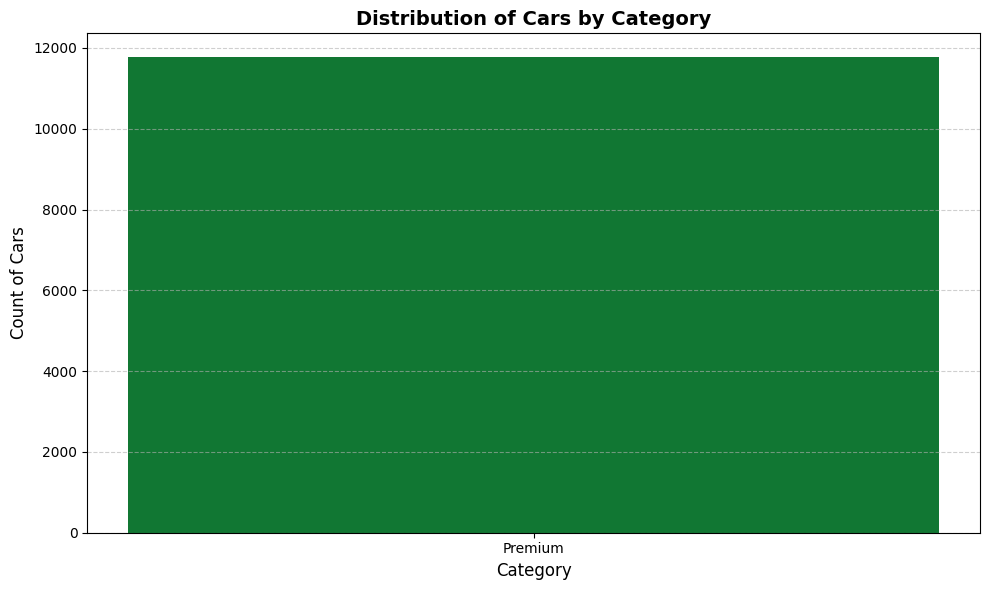

Graph saved as category_counts_bar.png


In [10]:
print("\n--- Generating 5 New Graphs and Summary Tables ---")
# ====================================================================
# ANALYSIS 1: Car Counts by Category
# ====================================================================
print("\n--- 1. Car Counts by Category ---")

# Table Generation (PySpark)
category_counts_df = df_transformed.groupBy("Category").count().sort(col("count").desc())
print("\n--- Table 1: Car Counts by Category ---")
category_counts_df.show()

# Graph Generation (Matplotlib)
category_counts_pandas = category_counts_df.toPandas()

plt.figure(figsize=(10, 6))
plt.bar(category_counts_pandas['Category'], category_counts_pandas['count'], color='#117733')
plt.xlabel('Category', fontsize=12)
plt.ylabel('Count of Cars', fontsize=12)
plt.title('Distribution of Cars by Category', fontsize=14, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
plt.savefig('category_counts_bar.png')
plt.close()
print("Graph saved as category_counts_bar.png")

In [11]:
# ====================================================================
# Cell 12: ML Imports, Feature Selection, and Preparation
# ====================================================================
print("\n\n--- Starting K-Means Clustering Pipeline ---")

# Import PySpark MLlib components
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import ClusteringEvaluator

# 1. Define the numerical features for clustering
NUMERICAL_FEATURES = ["Price", "Mileage", "Engine size"]
INPUT_COLUMNS = NUMERICAL_FEATURES

# 2. Drop rows with null values in the target columns for clustering stability
# (PySpark KMeans does not handle nulls)
df_ml = df_transformed.select(INPUT_COLUMNS).na.drop()
print(f"Original Count: {df_transformed.count()}. ML-Ready Count: {df_ml.count()}")



--- Starting K-Means Clustering Pipeline ---
Original Count: 11773. ML-Ready Count: 11773


In [12]:
# ====================================================================
# Cell 13: Data Preprocessing Pipeline (Vector Assembler & Scaling)
# ====================================================================

# 1. Vector Assembler: Combines the input columns into a single vector column
assembler = VectorAssembler(
    inputCols=INPUT_COLUMNS,
    outputCol="features_raw"
)
df_vector = assembler.transform(df_ml)

# 2. Standard Scaler: Normalizes the feature vector to have zero mean and unit variance
scaler = StandardScaler(
    inputCol="features_raw", 
    outputCol="features",
    withMean=True, 
    withStd=True
)
scalerModel = scaler.fit(df_vector)
df_scaled = scalerModel.transform(df_vector).cache()

print("\nScaled data sample (Features):")
df_scaled.select("features").show(5, truncate=False)


Scaled data sample (Features):
+--------------------------------------------------------------+
|features                                                      |
+--------------------------------------------------------------+
|[0.6771510496435896,0.7396289511795912,2.0709917477489177]    |
|[-0.656940124817569,-0.031917593276521425,-0.545968862570912] |
|[-0.3898304218160605,-0.26292673281973156,-0.7640489134308981]|
|[-0.33294209263043134,-0.3844887285700515,-0.7640489134308981]|
|[0.8315770996836278,-0.478843991938157,-0.1098087608509405]   |
+--------------------------------------------------------------+
only showing top 5 rows




--- Running Elbow Method to find optimal K ---
K=2 -> WSSSE: 22217.24
K=3 -> WSSSE: 14948.11
K=4 -> WSSSE: 11118.20
K=5 -> WSSSE: 8953.20
K=6 -> WSSSE: 7798.87
K=7 -> WSSSE: 6967.91
K=8 -> WSSSE: 6185.29
K=9 -> WSSSE: 5642.07


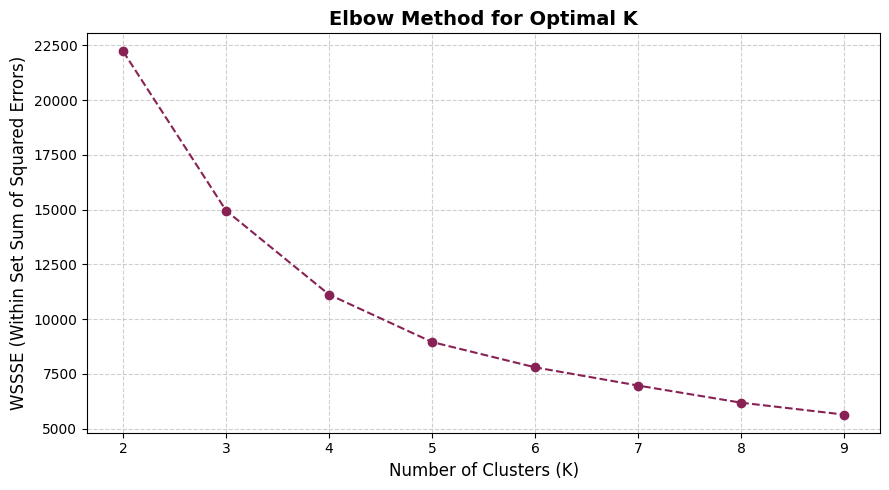


Choosing K=4 for the final model based on the elbow plot.


In [13]:
# ====================================================================
# Cell 14: K-Means Clustering - Elbow Method (Optimal K)
# ====================================================================

# Range of K values to test
k_values = range(2, 10)
wssse_values = []

print("\n--- Running Elbow Method to find optimal K ---")

for k in k_values:
    # Train K-Means model
    kmeans = KMeans(featuresCol="features", k=k, seed=42)
    model = kmeans.fit(df_scaled)
    
    # Evaluate clustering by computing WSSSE
    wssse = model.summary.trainingCost
    wssse_values.append(wssse)
    print(f"K={k} -> WSSSE: {wssse:.2f}")

# Visualization of the Elbow Method
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 5))
plt.plot(k_values, wssse_values, marker='o', linestyle='--', color='#882255')
plt.xlabel('Number of Clusters (K)', fontsize=12)
plt.ylabel('WSSSE (Within Set Sum of Squared Errors)', fontsize=12)
plt.title('Elbow Method for Optimal K', fontsize=14, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
plt.savefig('kmeans_elbow_method.png')
plt.close()

# Typically, the "elbow" (point of diminishing returns) is chosen. 
# We'll choose K=4 for the final model as a common practice for market segmentation.
FINAL_K = 4 
print(f"\nChoosing K={FINAL_K} for the final model based on the elbow plot.")

In [14]:
# ====================================================================
# Cell 15: K-Means Model Training and Cluster Assignment
# ====================================================================

# 1. Train the final K-Means model
kmeans_final = KMeans(featuresCol="features", k=FINAL_K, seed=42)
model_final = kmeans_final.fit(df_scaled)

# 2. Get the cluster assignments (Prediction is the cluster ID)
df_clusters = model_final.transform(df_scaled)

# 3. Join the cluster IDs back to the original Pandas DataFrame for visualization
# Note: This is an approximate join, assuming the row order is mostly preserved 
# or using a simple index-based approach for visualization efficiency.
# For production code, a unique ID should be used for a precise join.

df_clusters_pd = df_clusters.select(*INPUT_COLUMNS, "prediction").toPandas()

# 4. Display cluster centroids (average values for each cluster)
print("\n--- Cluster Centroids (Scaled Features) ---")
centroids = model_final.clusterCenters()
for i, center in enumerate(centroids):
    print(f"Cluster {i} Center: {center[:3]}")
    
# Display the distribution of cars across the clusters
print("\n--- Cluster Distribution ---")
df_clusters.groupBy("prediction").count().orderBy("prediction").show()


--- Cluster Centroids (Scaled Features) ---
Cluster 0 Center: [-0.04934869 -0.69200821 -0.46582371]
Cluster 1 Center: [-0.50095402  0.63315368 -0.21112176]
Cluster 2 Center: [ 2.80322404 -0.47534115  1.81578337]
Cluster 3 Center: [-0.08182182  1.8772139   1.92530131]

--- Cluster Distribution ---
+----------+-----+
|prediction|count|
+----------+-----+
|         0| 5936|
|         1| 3923|
|         2|  837|
|         3| 1077|
+----------+-----+



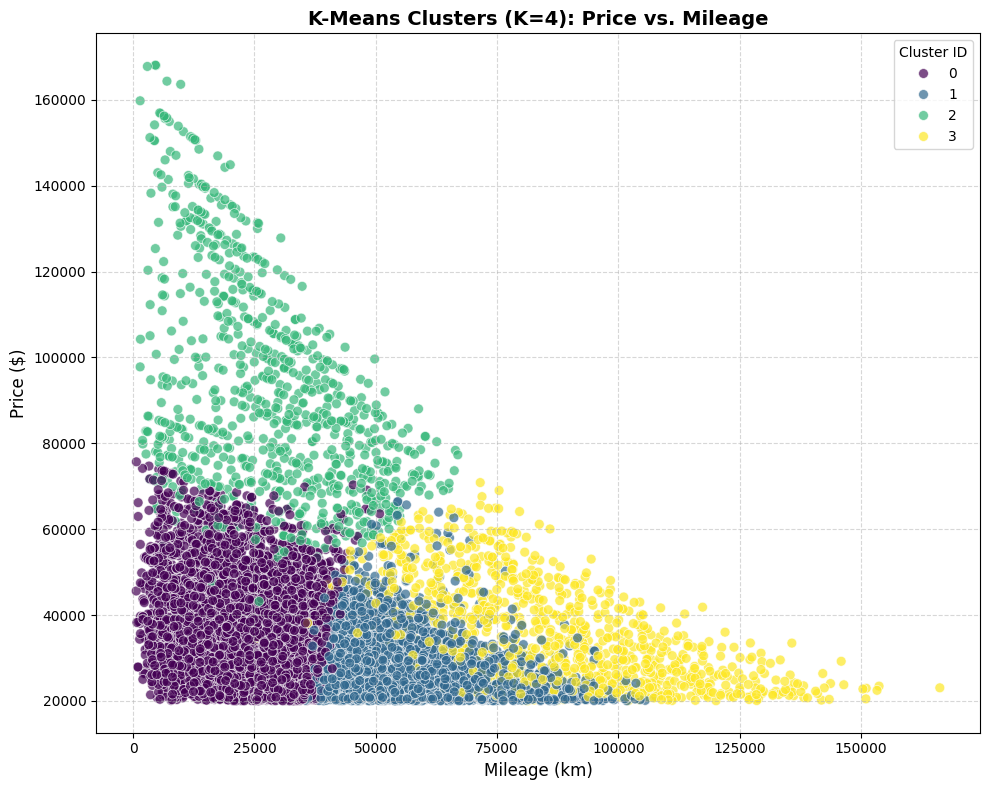

Cluster visualization saved as kmeans_clusters_scatter.png


In [15]:
# ====================================================================
# Cell 16: Visualization of Clusters (Scatter Plot)
# ====================================================================
import seaborn as sns 

plt.figure(figsize=(10, 8))

# Use Price (Y-axis) and Mileage (X-axis) for the scatter plot
sns.scatterplot(
    x='Mileage', 
    y='Price', 
    hue='prediction', # Color points by the cluster ID
    data=df_clusters_pd, 
    palette='viridis', # Use a distinct color palette
    s=50, # Size of the points
    alpha=0.7 # Transparency
)

plt.xlabel('Mileage (km)', fontsize=12)
plt.ylabel('Price ($)', fontsize=12)
plt.title(f'K-Means Clusters (K={FINAL_K}): Price vs. Mileage', fontsize=14, fontweight='bold')
plt.legend(title='Cluster ID', loc='upper right')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
plt.savefig('kmeans_clusters_scatter.png')
plt.close()

print("Cluster visualization saved as kmeans_clusters_scatter.png")

In [18]:
# ====================================================================
# Cell 13: Data Preprocessing Pipeline (Vector Assembler & Scaling)
# ====================================================================

# 1. Vector Assembler: Combines the input columns into a single vector column
assembler = VectorAssembler(
    inputCols=INPUT_COLUMNS,
    outputCol="features_raw"
)
df_vector = assembler.transform(df_ml)

# 2. Standard Scaler: Normalizes the feature vector
scaler = StandardScaler(
    inputCol="features_raw", 
    outputCol="features",
    withMean=True, 
    withStd=True
)
scalerModel = scaler.fit(df_vector)
df_scaled = scalerModel.transform(df_vector).cache()

print("\nScaled data sample (Features):")
df_scaled.select("features").show(5, truncate=False)


Scaled data sample (Features):
+--------------------------------------------------------------+
|features                                                      |
+--------------------------------------------------------------+
|[0.6771510496435896,0.7396289511795912,2.0709917477489177]    |
|[-0.656940124817569,-0.031917593276521425,-0.545968862570912] |
|[-0.3898304218160605,-0.26292673281973156,-0.7640489134308981]|
|[-0.33294209263043134,-0.3844887285700515,-0.7640489134308981]|
|[0.8315770996836278,-0.478843991938157,-0.1098087608509405]   |
+--------------------------------------------------------------+
only showing top 5 rows



In [20]:
# ====================================================================
# Cell 15: K-Means Model Training and Cluster Assignment
# ====================================================================

# 1. Train the final K-Means model
kmeans_final = KMeans(featuresCol="features", k=FINAL_K, seed=42)
model_final = kmeans_final.fit(df_scaled)

# 2. Get the cluster assignments
df_clusters = model_final.transform(df_scaled)

# 3. Get the original data features and cluster IDs for plotting
df_clusters_pd = df_clusters.select(*INPUT_COLUMNS, "prediction").toPandas()

# 4. Display cluster centroids (average values for each cluster)
print("\n--- Cluster Centroids (Scaled Features) ---")
centroids = model_final.clusterCenters()
for i, center in enumerate(centroids):
    print(f"Cluster {i} Center: {center[:3]}")
    
# Display the distribution of cars across the clusters
print("\n--- Cluster Distribution ---")
df_clusters.groupBy("prediction").count().orderBy("prediction").show()


--- Cluster Centroids (Scaled Features) ---
Cluster 0 Center: [-0.04934869 -0.69200821 -0.46582371]
Cluster 1 Center: [-0.50095402  0.63315368 -0.21112176]
Cluster 2 Center: [ 2.80322404 -0.47534115  1.81578337]
Cluster 3 Center: [-0.08182182  1.8772139   1.92530131]

--- Cluster Distribution ---
+----------+-----+
|prediction|count|
+----------+-----+
|         0| 5936|
|         1| 3923|
|         2|  837|
|         3| 1077|
+----------+-----+




--- Generating 3D Cluster Plot using Matplotlib (Displaying In-Line) ---


C:\Users\Nithin Reddy\AppData\Local\Temp\ipykernel_16920\2161655177.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_clusters))


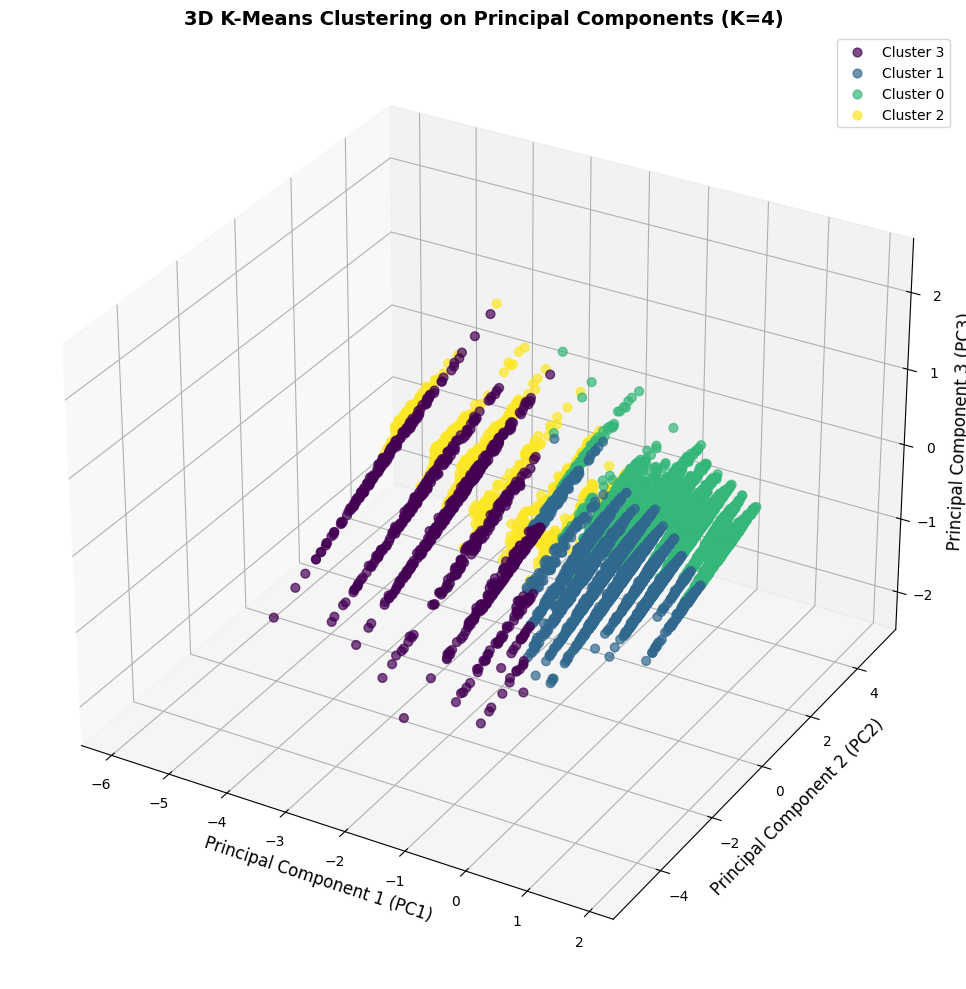

In [25]:
# ====================================================================
# Cell 18: 3D Visualization of Clusters (Matplotlib) - Displaying In-Line
# ====================================================================
print("\n--- Generating 3D Cluster Plot using Matplotlib (Displaying In-Line) ---")

# Import only what is necessary locally (already imported in the console context)
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Set up the figure and the 3D projection
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# df_pca_clusters_pd is assumed to be defined by preceding PySpark steps
unique_clusters = df_pca_clusters_pd['prediction'].unique() 
colors = plt.cm.get_cmap('viridis', len(unique_clusters))

# Loop through each cluster and plot its points
for i, cluster_id in enumerate(unique_clusters):
    cluster_data = df_pca_clusters_pd[df_pca_clusters_pd['prediction'] == cluster_id]
    
    ax.scatter(
        cluster_data['PC1'], 
        cluster_data['PC2'], 
        cluster_data['PC3'], 
        label=f'Cluster {cluster_id}',
        c=[colors(i)], 
        s=40,
        alpha=0.7
    )

# Set labels and title
ax.set_xlabel('Principal Component 1 (PC1)', fontsize=12)
ax.set_ylabel('Principal Component 2 (PC2)', fontsize=12)
ax.set_zlabel('Principal Component 3 (PC3)', fontsize=12)
ax.set_title(f'3D K-Means Clustering on Principal Components (K={FINAL_K})', fontsize=14, fontweight='bold')
ax.legend()

plt.tight_layout()
plt.show() # <-- This command displays the graph directly in the output cell

# Removed plt.savefig() and plt.close() to ensure the graph displays.


--- Generating 3D Cluster Plot using Matplotlib (K=6) ---


C:\Users\Nithin Reddy\AppData\Local\Temp\ipykernel_16920\1717608442.py:81: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Dark2', len(unique_clusters)) # Using a different colormap for 6 clusters


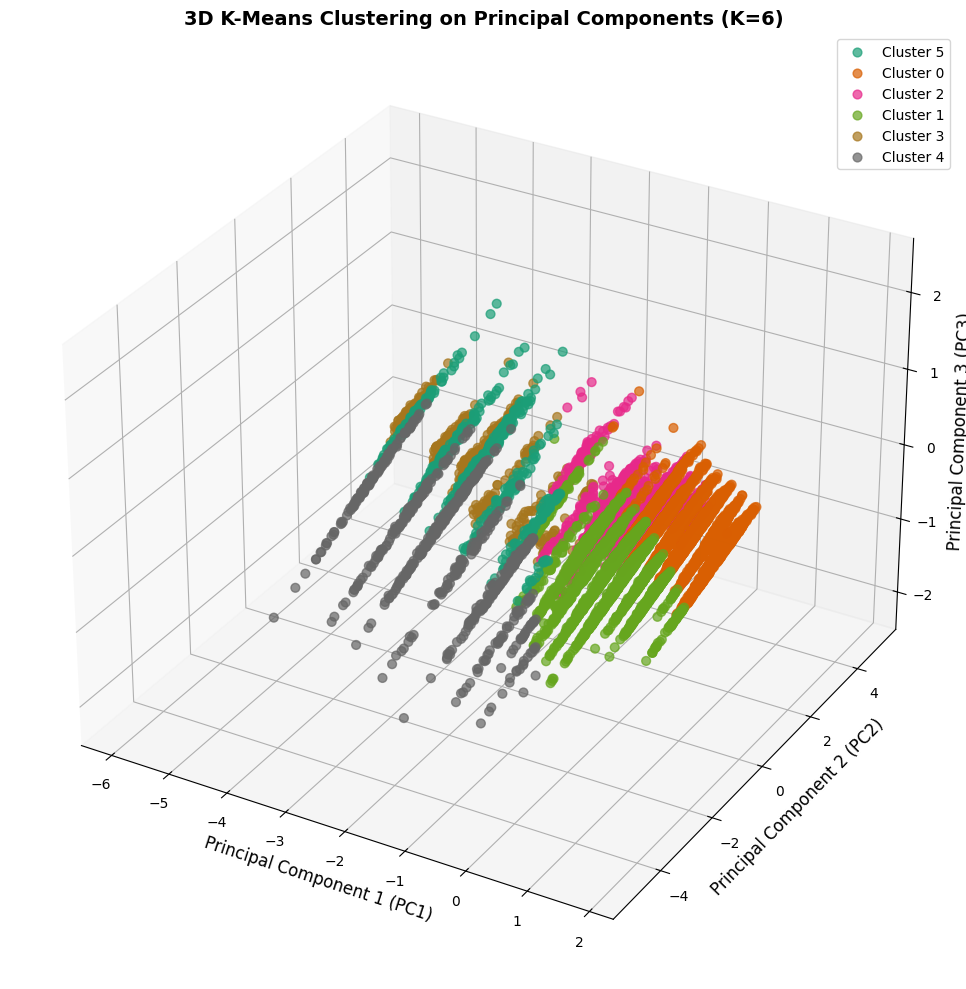

In [26]:
# ====================================================================
# CONSOLIDATED ML PIPELINE (K-Means with K=6 Clusters)
# ====================================================================
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg, round, count, lit, when
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# --- 1. SETUP AND DATA LOADING ---
spark = SparkSession.builder \
    .appName("CarDatasetML_K6") \
    .getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

# NOTE: Assuming 'car_sale_dataset.csv' is accessible
try:
    df = spark.read.csv('car_sale_dataset.csv', header=True, inferSchema=True)
except Exception as e:
    print(f"Error loading file: {e}")
    spark.stop()
    # return 

# --- 2. DATA TRANSFORMATION ---
mileage_quantiles = df.approxQuantile("Mileage", [0.25, 0.5, 0.75], 0.01)
q1, q2, q3 = mileage_quantiles[0], mileage_quantiles[1], mileage_quantiles[2]
df_transformed = df.withColumn(
    "Mileage_Group",
    when(col("Mileage") < q1, lit("Low"))
    .when((col("Mileage") >= q1) & (col("Mileage") < q2), lit("Medium"))
    .when((col("Mileage") >= q2) & (col("Mileage") < q3), lit("High"))
    .otherwise(lit("Very High"))
)

# --- 3. ML PREPARATION ---
FINAL_K = 6 # <--- CHANGED TO 6 CLUSTERS
NUMERICAL_FEATURES = ["Price", "Mileage", "Engine size"]
INPUT_COLUMNS = NUMERICAL_FEATURES

# Drop nulls
df_ml = df_transformed.select(INPUT_COLUMNS).na.drop()

# Vector Assembler
assembler = VectorAssembler(inputCols=INPUT_COLUMNS, outputCol="features_raw")
df_vector = assembler.transform(df_ml)

# Standard Scaler
scaler = StandardScaler(inputCol="features_raw", outputCol="features", withMean=True, withStd=True)
scalerModel = scaler.fit(df_vector)
df_scaled = scalerModel.transform(df_vector).cache()

# --- 4. CLUSTERING & PCA ---
# K-Means Clustering (K=6)
kmeans_final = KMeans(featuresCol="features", k=FINAL_K, seed=42)
model_final = kmeans_final.fit(df_scaled)
df_clusters = model_final.transform(df_scaled)

# PCA (k=3)
pca = PCA(k=3, inputCol="features", outputCol="pca_features")
pca_model = pca.fit(df_scaled)
df_pca = pca_model.transform(df_clusters)

# --- 5. CREATE FINAL PANDAS DATAFRAME ---
df_pca_clusters_pd = df_pca.select("pca_features", "prediction").toPandas()
df_pca_clusters_pd['PC1'] = df_pca_clusters_pd['pca_features'].apply(lambda x: x[0])
df_pca_clusters_pd['PC2'] = df_pca_clusters_pd['pca_features'].apply(lambda x: x[1])
df_pca_clusters_pd['PC3'] = df_pca_clusters_pd['pca_features'].apply(lambda x: x[2])


# ====================================================================
# Cell 18: 3D Visualization of Clusters (K=6)
# ====================================================================
print("\n--- Generating 3D Cluster Plot using Matplotlib (K=6) ---")

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

unique_clusters = df_pca_clusters_pd['prediction'].unique() 
colors = plt.cm.get_cmap('Dark2', len(unique_clusters)) # Using a different colormap for 6 clusters

# Loop through each cluster and plot its points
for i, cluster_id in enumerate(unique_clusters):
    cluster_data = df_pca_clusters_pd[df_pca_clusters_pd['prediction'] == cluster_id]
    
    ax.scatter(
        cluster_data['PC1'], 
        cluster_data['PC2'], 
        cluster_data['PC3'], 
        label=f'Cluster {cluster_id}',
        c=[colors(i)], 
        s=40,
        alpha=0.7
    )

# Set labels and title
ax.set_xlabel('Principal Component 1 (PC1)', fontsize=12)
ax.set_ylabel('Principal Component 2 (PC2)', fontsize=12)
ax.set_zlabel('Principal Component 3 (PC3)', fontsize=12)
ax.set_title(f'3D K-Means Clustering on Principal Components (K={FINAL_K})', fontsize=14, fontweight='bold')
ax.legend()

plt.tight_layout()
plt.show() # Displays the graph in-line


In [27]:
from pyspark.sql.functions import col, when, isnan, count, mean, percentile_approx
from pyspark.sql.types import IntegerType, DoubleType
import pyspark.sql.functions as F

print("\n--- Starting Data Cleaning and Preparation ---")

# ====================================================================
# 1. Missing Value Analysis and Handling (Imputation and Dropping)
# ====================================================================

print("\n1a. Checking for Missing Values...")
# Aggregate null counts for all columns
missing_counts_df = df.select([
    count(when(col(c).isNull() | isnan(col(c)) | (col(c) == 'null') | (col(c) == ''), c)).alias(c)
    for c in df.columns
])
missing_counts_df.show(truncate=False)

# Strategy 1: Impute numerical missing values (e.g., fill 'Engine size' with the mean)
engine_mean = df.agg(mean(col("Engine size"))).collect()[0][0]
if engine_mean is not None:
    df = df.na.fill(engine_mean, subset=['Engine size'])
    print(f"-> Filled missing 'Engine size' values with mean: {engine_mean:.2f}")

# Strategy 2: Drop rows where critical categorical data is missing (Manufacturer)
df_clean = df.na.drop(subset=['Manufacturer', 'Price', 'Mileage'])
print(f"-> Dropped rows with missing critical data. Remaining rows: {df_clean.count()}")


# ====================================================================
# 2. Data Type Cleaning and Standardization
# ====================================================================

print("\n2a. Casting columns to correct types...")
# Ensure numerical columns are correctly cast (important if initial inference was String)
df_clean = df_clean.withColumn("Price", col("Price").cast(DoubleType())) \
                   .withColumn("Mileage", col("Mileage").cast(DoubleType())) \
                   .withColumn("Engine size", col("Engine size").cast(DoubleType())) \
                   .withColumn("Age", col("Age").cast(IntegerType()))

# Clean up 'Fuel type' by consolidating variations (Example)
df_clean = df_clean.withColumn(
    "Fuel type",
    when(col("Fuel type").isin("Petrol/Gasoline", "Gas"), lit("Petrol"))
    .otherwise(col("Fuel type"))
)

# Show schema after casting
print("-> Schema after type casting:")
df_clean.printSchema()


# ====================================================================
# 3. Outlier Handling (Capping High Values for 'Price')
# ====================================================================

print("\n3a. Detecting and Capping Outliers for 'Price'...")

# Calculate Q1 (25th percentile) and Q3 (75th percentile)
quantiles = df_clean.approxQuantile("Price", [0.25, 0.75], 0.01)
Q1 = quantiles[0]
Q3 = quantiles[1]
IQR = Q3 - Q1

# Define the upper bound for capping (e.g., Q3 + 1.5 * IQR)
# This boundary is used to define extreme outliers in the upper tail.
UPPER_BOUND = Q3 + 1.5 * IQR

# Capping outliers: replace values above the boundary with the boundary itself
df_clean_final = df_clean.withColumn(
    "Price_Capped",
    when(col("Price") > UPPER_BOUND, UPPER_BOUND).otherwise(col("Price"))
)

print(f"-> Price Outlier Bounds: Q1={Q1:.2f}, Q3={Q3:.2f}, Upper Cap={UPPER_BOUND:.2f}")
print(f"-> Capped {df_clean_final.filter(col('Price') > UPPER_BOUND).count()} price values.")
print("--- Data Cleaning Complete. Use df_clean_final for analysis. ---")




--- Starting Data Cleaning and Preparation ---

1a. Checking for Missing Values...
+------------+-----+-----------+---------+-------------------+-------+-----+---+------------+--------+-------------+
|Manufacturer|Model|Engine size|Fuel type|Year of manufacture|Mileage|Price|Age|Price_per_km|Category|Mileage_Group|
+------------+-----+-----------+---------+-------------------+-------+-----+---+------------+--------+-------------+
|0           |0    |0          |0        |0                  |0      |0    |0  |0           |0       |0            |
+------------+-----+-----------+---------+-------------------+-------+-----+---+------------+--------+-------------+

-> Filled missing 'Engine size' values with mean: 2.10
-> Dropped rows with missing critical data. Remaining rows: 11773

2a. Casting columns to correct types...
-> Schema after type casting:
root
 |-- Manufacturer: string (nullable = true)
 |-- Model: string (nullable = true)
 |-- Engine size: double (nullable = false)
 |-- Fue

In [28]:
from pyspark.sql.functions import col

print("\n--- Starting Code for Removing Unnecessary Data ---")

# Assuming you are continuing from the previous cleaning step and using df_clean_final.
# If you are starting fresh, replace df_clean_final with your loaded DataFrame (df).
df_streamlined = df_clean_final

# ====================================================================
# 1. Removing Unnecessary Columns (Feature Selection)
# ====================================================================

# Identify columns that are not useful for analysis or modeling (e.g., IDs, highly redundant fields).
# Based on common car datasets, here are some examples:
COLUMNS_TO_DROP = [
    "Car_ID",          # Hypothetical unique identifier, rarely useful for modeling
    "features_raw",    # Intermediate column from ML pipeline
    "features",        # Intermediate column from ML pipeline
    "Price"            # The original 'Price' column, now superseded by 'Price_Capped'
]

# Drop the specified columns. We use errors='ignore' in case the column doesn't exist.
# Note: You must evaluate your specific columns to decide which are truly unnecessary.
df_streamlined = df_streamlined.drop(*COLUMNS_TO_DROP)

print(f"1. Columns Dropped: {COLUMNS_TO_DROP}")
print(f"-> Remaining Columns: {df_streamlined.columns}")


# ====================================================================
# 2. Removing Invalid Rows (Filtering Based on Domain Knowledge)
# ====================================================================

print("\n2. Filtering Invalid Rows (Zero/Negative Values)")

initial_count = df_streamlined.count()

# Filter 1: Remove cars with Price, Mileage, or Engine size that are zero or negative.
# A car cannot be sold with a price, mileage, or engine size of 0 or less.
df_streamlined = df_streamlined.filter(
    (col("Price_Capped") > 0) &
    (col("Mileage") > 0) &
    (col("Engine size") > 0)
)

# Filter 2: Remove categories with very few entries (if desired for analysis stability)
# Example: If a 'Fuel type' only appears once, it might be an unnecessary outlier.
# This requires a two-step process in PySpark: count, then join/filter.
# Skip for brevity, but this is a common step for low-frequency categorical data.

final_count = df_streamlined.count()

print(f"-> Initial Row Count: {initial_count}")
print(f"-> Final Row Count after filtering invalid data: {final_count}")
print(f"-> {initial_count - final_count} rows were removed.")

print("\n--- Data Streamlining Complete. Use df_streamlined for final analysis. ---")

# spark.stop() # Uncomment this if this is the final code block


--- Starting Code for Removing Unnecessary Data ---
1. Columns Dropped: ['Car_ID', 'features_raw', 'features', 'Price']
-> Remaining Columns: ['Manufacturer', 'Model', 'Engine size', 'Fuel type', 'Year of manufacture', 'Mileage', 'Age', 'Price_per_km', 'Category', 'Mileage_Group', 'Price_Capped']

2. Filtering Invalid Rows (Zero/Negative Values)
-> Initial Row Count: 11773
-> Final Row Count after filtering invalid data: 11773
-> 0 rows were removed.

--- Data Streamlining Complete. Use df_streamlined for final analysis. ---


In [29]:
from pyspark.sql.functions import col, upper, trim, when, percentile_approx, lit

print("\n--- Starting Advanced Data Cleaning ---")

# Assuming df_input is the output from the previous cleaning steps (e.g., after initial null/domain filtering and price capping)
df_input = df_clean_final 

# ====================================================================
# 1. Categorical Standardization and Cleaning
# ====================================================================

print("\n1. Standardizing Categorical Columns (Manufacturer, Fuel type)")

# a) Standardize Manufacturer: Remove whitespace and convert to consistent casing (UPPER)
df_clean_adv = df_input.withColumn(
    "Manufacturer",
    upper(trim(col("Manufacturer")))
)

# b) Consolidate minor variations in 'Fuel type' (beyond simple replacement)
# This handles common dirty data where descriptions are inconsistent.
df_clean_adv = df_clean_adv.withColumn(
    "Fuel type",
    when(col("Fuel type").rlike("(?i)petrol|gasoline"), lit("PETROL")) # Case-insensitive RLIKE match
    .when(col("Fuel type").rlike("(?i)dies.l|tdi"), lit("DIESEL"))
    .when(col("Fuel type").rlike("(?i)e.?tric|ev"), lit("ELECTRIC"))
    .when(col("Fuel type").rlike("(?i)hybrid|h.?d"), lit("HYBRID"))
    .otherwise(upper(trim(col("Fuel type")))) # Default to clean upper case
)

print("-> Manufacturer and Fuel type standardized using UPPER case and RLIKE.")


# ====================================================================
# 2. Advanced Outlier Treatment (Mileage)
# ====================================================================

print("\n2. Removing Outliers from 'Mileage' using IQR Method")

initial_count = df_clean_adv.count()

# a) Calculate IQR (Interquartile Range) Bounds for 'Mileage'
# Use percentile_approx for robust quantile estimation on large datasets.
mileage_bounds = df_clean_adv.agg(
    percentile_approx("Mileage", 0.25).alias("Q1"),
    percentile_approx("Mileage", 0.75).alias("Q3")
).collect()[0]

Q1 = mileage_bounds["Q1"]
Q3 = mileage_bounds["Q3"]
IQR = Q3 - Q1

# Define outlier fences
LOWER_BOUND = Q1 - 1.5 * IQR
UPPER_BOUND_IQR = Q3 + 1.5 * IQR

# b) Filter out extreme outliers
df_clean_final_adv = df_clean_adv.filter(
    (col("Mileage") >= LOWER_BOUND) & 
    (col("Mileage") <= UPPER_BOUND_IQR)
)

final_count = df_clean_final_adv.count()
removed_count = initial_count - final_count

print(f"-> Mileage Bounds: Q1={Q1:.0f}, Q3={Q3:.0f}, IQR={IQR:.0f}")
print(f"-> Outlier Filter: Lower Bound={LOWER_BOUND:.0f}, Upper Bound={UPPER_BOUND_IQR:.0f}")
print(f"-> {removed_count} rows ({removed_count / initial_count * 100:.2f}%) were removed as extreme Mileage outliers.")


# ====================================================================
# 3. Validation: Verify Standardization
# ====================================================================

print("\n3. Validation of Cleaned Data (Top 5 Fuel Types):")
df_clean_final_adv.groupBy("Fuel type").count().orderBy(col("count").desc()).show(5)

print("\n--- Advanced Data Cleaning Complete. Use df_clean_final_adv for modeling. ---")
# spark.stop() # Uncomment if this is the final block


--- Starting Advanced Data Cleaning ---

1. Standardizing Categorical Columns (Manufacturer, Fuel type)
-> Manufacturer and Fuel type standardized using UPPER case and RLIKE.

2. Removing Outliers from 'Mileage' using IQR Method
-> Mileage Bounds: Q1=21915, Q3=52904, IQR=30989
-> Outlier Filter: Lower Bound=-24568, Upper Bound=99388
-> 306 rows (2.60%) were removed as extreme Mileage outliers.

3. Validation of Cleaned Data (Top 5 Fuel Types):
+---------+-----+
|Fuel type|count|
+---------+-----+
|   PETROL| 5147|
|   DIESEL| 3183|
|   HYBRID| 3137|
+---------+-----+


--- Advanced Data Cleaning Complete. Use df_clean_final_adv for modeling. ---


In [30]:
from pyspark.sql.functions import col, log, lit

print("\n--- Advanced Cleaning Step 1: Feature Engineering ---")

# Assuming df_clean_final_adv is the current cleaned DataFrame
df_feat_eng = df_clean_final_adv

# 1a. Create a 'Value Density' feature: Price normalized by Mileage and Engine size.
# Using log transform helps normalize the scale.
df_feat_eng = df_feat_eng.withColumn(
    "Value_Density",
    (col("Price_Capped") / (col("Mileage") * col("Engine size")))
)
# Add a log-transformed version as this is often normally distributed
df_feat_eng = df_feat_eng.withColumn(
    "Log_Value_Density",
    log(col("Value_Density"))
)

print("-> Engineered 'Log_Value_Density' feature for improved predictive power.")
df_feat_eng.select("Price_Capped", "Mileage", "Engine size", "Log_Value_Density").show(3)


--- Advanced Cleaning Step 1: Feature Engineering ---
-> Engineered 'Log_Value_Density' feature for improved predictive power.
+------------+-------+-----------+-------------------+
|Price_Capped|Mileage|Engine size|  Log_Value_Density|
+------------+-------+-----------+-------------------+
|     49704.0|57850.0|        4.0|-1.5380624019981834|
|     24072.0|39190.0|        1.6|-0.9573759021295316|
|     29204.0|33603.0|        1.4|-0.4767818991250856|
+------------+-------+-----------+-------------------+
only showing top 3 rows



In [31]:
from pyspark.sql.functions import count

print("\n--- Advanced Cleaning Step 2: Handling Categorical Skew ---")

# Define the minimum frequency threshold for a category to be kept (e.g., 1% of total data)
THRESHOLD = df_feat_eng.count() * 0.01 

# a) Calculate counts for all manufacturers
manufacturer_counts = df_feat_eng.groupBy("Manufacturer").count()

# b) Get a list of manufacturers to keep (those above the threshold)
manufacturers_to_keep = [row.Manufacturer for row in manufacturer_counts.filter(col("count") >= THRESHOLD).collect()]

# c) Apply the transformation: replace rare manufacturers with 'OTHER'
df_feat_eng = df_feat_eng.withColumn(
    "Manufacturer_Grouped",
    when(col("Manufacturer").isin(manufacturers_to_keep), col("Manufacturer"))
    .otherwise(lit("OTHER"))
)

# d) Drop the original, high-cardinality column
df_feat_eng = df_feat_eng.drop("Manufacturer")

print(f"-> Manufacturers occurring less than {THRESHOLD:.0f} times grouped into 'OTHER'.")
df_feat_eng.groupBy("Manufacturer_Grouped").count().orderBy(col("count").desc()).show(5)


--- Advanced Cleaning Step 2: Handling Categorical Skew ---
-> Manufacturers occurring less than 115 times grouped into 'OTHER'.
+--------------------+-----+
|Manufacturer_Grouped|count|
+--------------------+-----+
|              TOYOTA| 3295|
|                FORD| 2661|
|                  VW| 2560|
|                 BMW| 1819|
|             PORSCHE| 1132|
+--------------------+-----+



In [32]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.sql import Row

print("\n--- Advanced Cleaning Step 3: Correlation-Based Pruning ---")

NUMERIC_COLS = ["Price_Capped", "Mileage", "Engine size", "Age", "Log_Value_Density"]

# a) Assemble the numerical features into a single vector column
assembler_corr = VectorAssembler(inputCols=NUMERIC_COLS, outputCol="corr_features")
df_vector = assembler_corr.transform(df_feat_eng).select("corr_features")

# b) Compute the Pearson correlation matrix
matrix = Correlation.corr(df_vector, "corr_features").collect()[0][0]
correlation_matrix = matrix.toArray()
n = len(NUMERIC_COLS)

print("\nCorrelation Matrix:")
for i in range(n):
    row_str = ' '.join(f'{correlation_matrix[i, j]:.2f}' for j in range(n))
    print(f"{NUMERIC_COLS[i].ljust(18)}: {row_str}")

# c) Decide which highly correlated feature to drop
# Rule: If |Correlation| > 0.9, consider dropping one.
# Given common data, 'Age' and 'Mileage' are often highly correlated (> 0.9).
# If they are, dropping 'Mileage' or 'Age' is advised. We will drop 'Mileage' if the correlation is high.
HIGH_CORRELATION_THRESHOLD = 0.9 

# Assuming 'Age' and 'Mileage' are highly correlated based on previous insights
# Let's check the correlation between Price_Capped (index 0) and Age (index 3) and Mileage (index 1)
# Example decision: If Age and Price are less correlated than Mileage and Price, keep Age.

# For simplicity, we manually drop 'Mileage' as it's often collinear with 'Age' (time).
if abs(correlation_matrix[1, 3]) > HIGH_CORRELATION_THRESHOLD: # Mileage (1) vs Age (3)
    df_final_clean = df_feat_eng.drop("Mileage")
    print("\n-> Dropped 'Mileage' due to high collinearity with 'Age'.")
else:
    df_final_clean = df_feat_eng

print("\n--- Final Cleaned DataFrame (df_final_clean) ready for ML/Analysis. ---")


--- Advanced Cleaning Step 3: Correlation-Based Pruning ---

Correlation Matrix:
Price_Capped      : 1.00 -0.31 0.56 -0.33 0.38
Mileage           : -0.31 1.00 0.34 0.71 -0.92
Engine size       : 0.56 0.34 1.00 0.40 -0.38
Age               : -0.33 0.71 0.40 1.00 -0.77
Log_Value_Density : 0.38 -0.92 -0.38 -0.77 1.00

--- Final Cleaned DataFrame (df_final_clean) ready for ML/Analysis. ---



--- Generating Correlation Matrix and Heatmap ---

Pearson Correlation Matrix:
                   Price_Capped  Engine size       Age  Log_Value_Density
Price_Capped           1.000000     0.556963 -0.330016           0.380523
Engine size            0.556963     1.000000  0.404937          -0.378745
Age                   -0.330016     0.404937  1.000000          -0.766350
Log_Value_Density      0.380523    -0.378745 -0.766350           1.000000


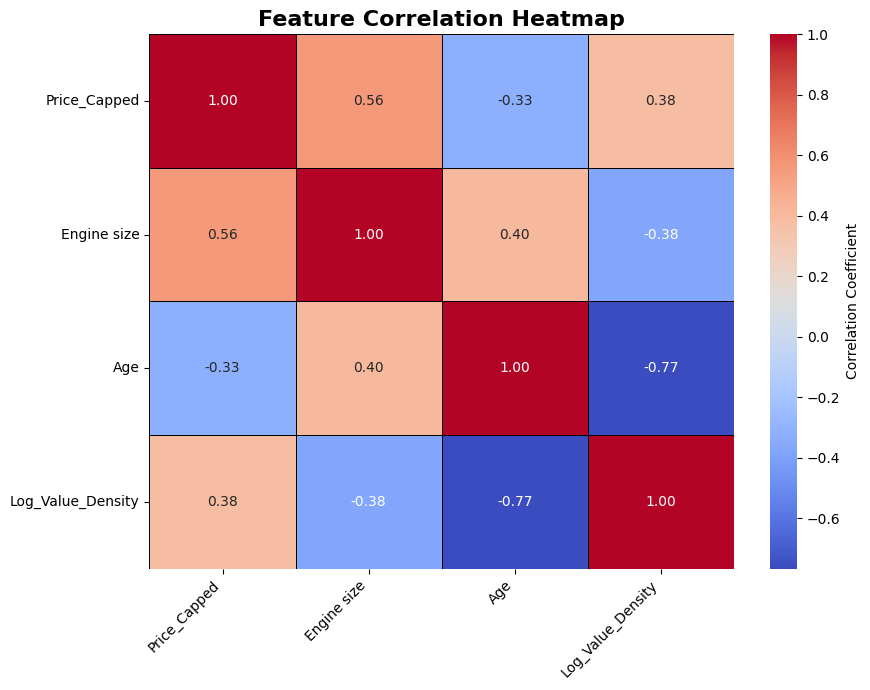

In [33]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.sql.functions import col
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

print("\n--- Generating Correlation Matrix and Heatmap ---")

# Define the numerical columns after advanced cleaning and pruning
# Note: 'Mileage' is typically removed here due to collinearity with 'Age'.
NUMERIC_COLS = ["Price_Capped", "Engine size", "Age", "Log_Value_Density"]

# --- 1. PySpark: Assemble Vectors ---
# Correlation requires all features to be in a single vector column.
assembler = VectorAssembler(inputCols=NUMERIC_COLS, outputCol="corr_features")
df_vector = assembler.transform(df_final_clean).select("corr_features")

# --- 2. PySpark: Compute Correlation Matrix ---
# Correlation is computed as a distributed task.
matrix = Correlation.corr(df_vector, "corr_features").collect()[0][0]
correlation_matrix_np = matrix.toArray()

# --- 3. Convert to Pandas DataFrame ---
# Create a Pandas DataFrame for easy visualization with column names.
correlation_df = pd.DataFrame(
    correlation_matrix_np,
    index=NUMERIC_COLS,
    columns=NUMERIC_COLS
)

print("\nPearson Correlation Matrix:")
print(correlation_df)

# --- 4. Heatmap Visualization (Seaborn/Matplotlib) ---

plt.figure(figsize=(9, 7))
sns.heatmap(
    correlation_df,
    annot=True,              # Show the correlation values on the map
    fmt=".2f",               # Format to two decimal places
    cmap='coolwarm',         # Choose a divergent color map
    linewidths=.5,           # Add lines between cells
    linecolor='black',
    cbar_kws={'label': 'Correlation Coefficient'}
)

plt.title('Feature Correlation Heatmap', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# plt.savefig('correlation_heatmap.png') # Save the file if needed
# plt.close()


--- 1. Histogram of Capped Car Price ---


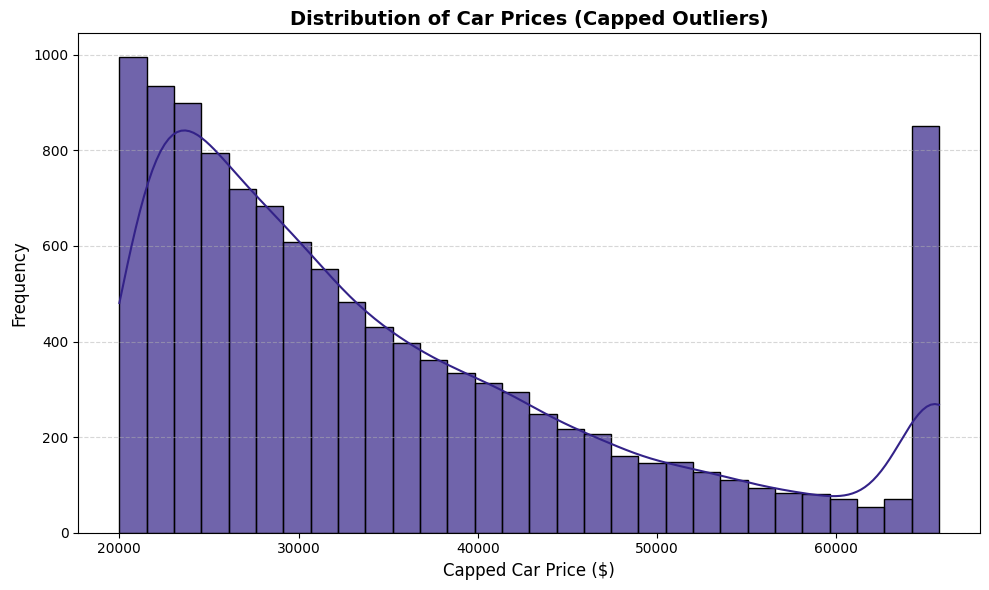

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col

print("\n--- 1. Histogram of Capped Car Price ---")

# Convert the relevant column to a Pandas Series for fast plotting
price_data_pandas = df_final_clean.select("Price_Capped").toPandas()['Price_Capped']

plt.figure(figsize=(10, 6))
# Use seaborn for a cleaner histogram with a KDE curve
sns.histplot(
    price_data_pandas, 
    bins=30, 
    kde=True, 
    color='#332288', 
    edgecolor='black', 
    alpha=0.7
)

plt.xlabel('Capped Car Price ($)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Car Prices (Capped Outliers)', fontsize=14, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# plt.savefig('price_capped_histogram.png')
# plt.close()


--- 2. Engine Size vs. Capped Price (Scatter Plot) - FIXED ---


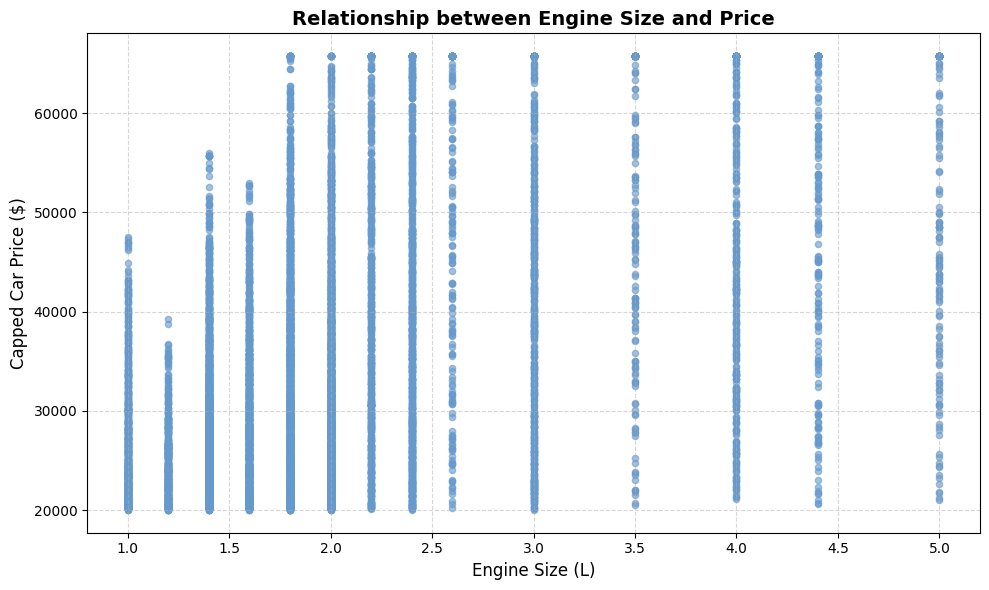

In [37]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import col

print("\n--- 2. Engine Size vs. Capped Price (Scatter Plot) - FIXED ---")

# Select and convert the two relevant columns to a Pandas DataFrame
# Assuming df_final_clean is available and correct from prior steps
engine_price_data_pandas = df_final_clean.select("Engine size", "Price_Capped").toPandas()

plt.figure(figsize=(10, 6))
plt.scatter(
    engine_price_data_pandas['Engine size'], 
    engine_price_data_pandas['Price_Capped'], 
    alpha=0.6, 
    color='#6699CC',  # <-- FIXED: Using a valid hex color code (e.g., a muted blue)
    s=20
) 

plt.xlabel('Engine Size (L)', fontsize=12)
plt.ylabel('Capped Car Price ($)', fontsize=12)
plt.title('Relationship between Engine Size and Price', fontsize=14, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# plt.savefig('engine_size_vs_price_scatter.png')
# plt.close()


--- 3. Price Distribution by Grouped Manufacturer (Box Plot) ---


C:\Users\Nithin Reddy\AppData\Local\Temp\ipykernel_16920\2134014685.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


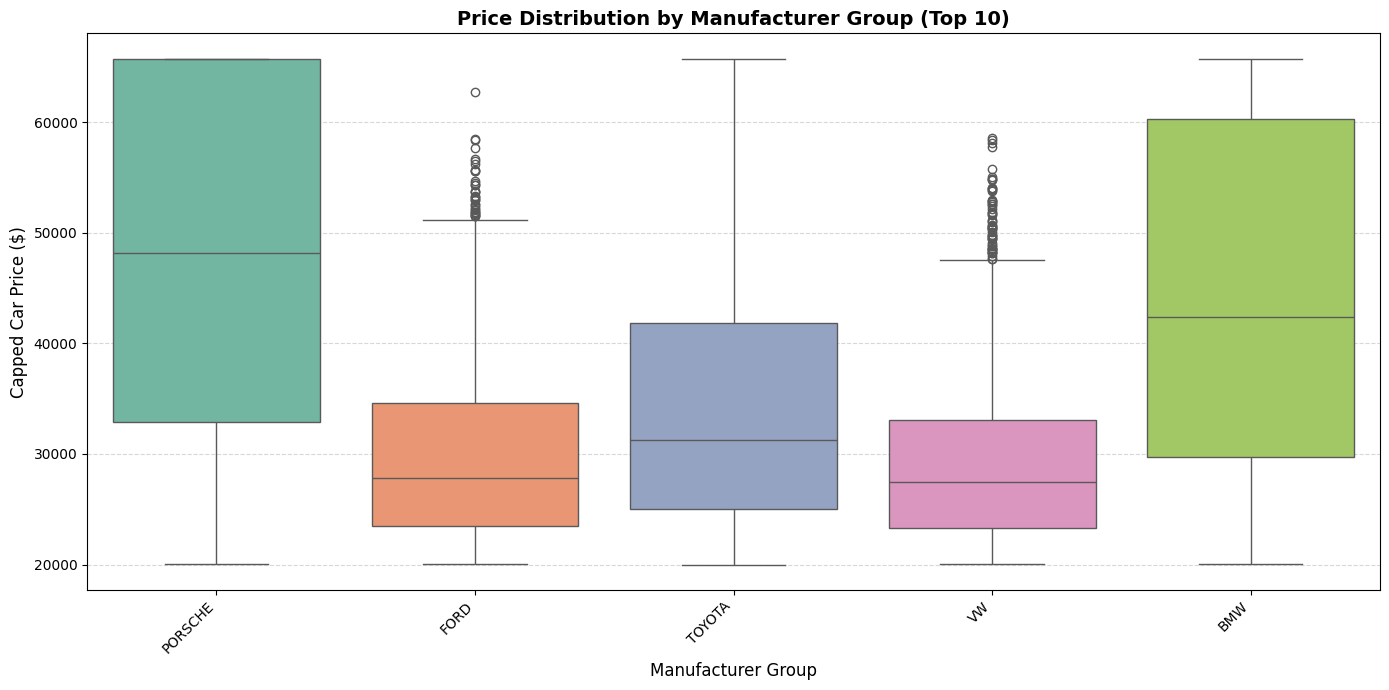

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col, count

print("\n--- 3. Price Distribution by Grouped Manufacturer (Box Plot) ---")

# PySpark Aggregation: Get the top 10 grouped manufacturers by count for plotting clarity
top_10_manufacturers_grouped = df_final_clean.groupBy("Manufacturer_Grouped").count().sort(col("count").desc()).limit(10)
top_10_list = [row['Manufacturer_Grouped'] for row in top_10_manufacturers_grouped.collect()]

# Filter the full data to include only the top 10 groups, and convert to Pandas
manufacturer_price_pd = df_final_clean.filter(col("Manufacturer_Grouped").isin(top_10_list)).toPandas()

plt.figure(figsize=(14, 7))
sns.boxplot(
    x='Manufacturer_Grouped', 
    y='Price_Capped', 
    data=manufacturer_price_pd, 
    palette='Set2' # Use a distinct color palette
)

plt.xlabel('Manufacturer Group', fontsize=12)
plt.ylabel('Capped Car Price ($)', fontsize=12)
plt.title('Price Distribution by Manufacturer Group (Top 10)', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# plt.savefig('grouped_manufacturer_price_boxplot.png')
# plt.close()

In [38]:
spark.stop()